# Forecasting Energy Demand 

## Exploratory Data Analysis (EDA)
The main question we want to answer is what is the relationship between the independent variables (weather features) and the dependent variable (electricity demand).

To get a feel for what is going on in the data and what we expect to be important/influential features in the model, we'll look at summary statistics and visualizations of the data before building a model

In [1]:
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm 
import seaborn as sns

In [3]:
CITY = 'LosAngeles'
df_file = 'dataframes/%s_dataset.csv' % CITY

df_location = 's3://{}/{}'.format(bucket, df_file)
df = pd.read_csv(df_location, index_col ='datetime', parse_dates=True)

(array([ 5714., 10888., 12043.,  5194.,  2318.,  1599.,   970.,   470.,
          181.,    45.]),
 array([2019. , 2504.1, 2989.2, 3474.3, 3959.4, 4444.5, 4929.6, 5414.7,
        5899.8, 6384.9, 6870. ]),
 <a list of 10 Patch objects>)

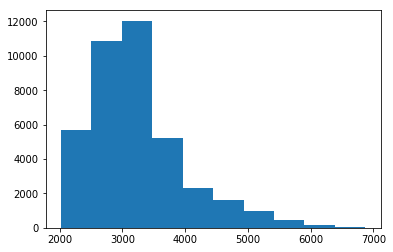

In [4]:
plt.hist(df.demand)

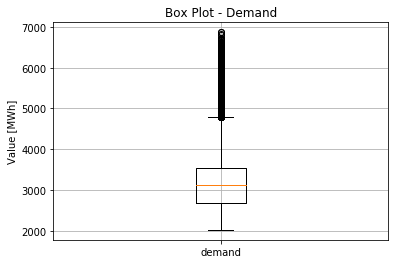

In [5]:
plt.boxplot([df['demand']], labels=['demand'])
plt.title('Box Plot - Demand')
plt.ylabel('Value [MWh]')
plt.grid(True)

In [6]:
# get pearson correlation coefficients for demand
print('DEMAND CORRELATIONS (PEARSON)')
print(df.corr()['demand'].sort_values(ascending=False)[1:])

# get r^2 values per column and print
demand_r = {}
for col in df.columns:
    if col != 'demand':
        if col != 'date':
            slope, intercept, r_value, p_value, std_err = scipy.stats.stats.linregress(df['demand'], df[col])
            demand_r[col] = float(r_value**2)

print(' ')
print('***')
print(' ')
print('DEMAND CORRELATIONS (r^2)')
demand_r_df = pd.DataFrame({'col': list(demand_r.keys()), 'r^2': list(demand_r.values())})
print(demand_r_df.sort_values(by='r^2', ascending=False))

DEMAND CORRELATIONS (PEARSON)
dailycoolingdegreedays       0.554611
hourlyrelativehumidity       0.364436
hourlydewpointtemperature    0.361349
hourlyskyconditions_CLR      0.030553
hourlyskyconditions_OVC      0.008307
hourlydrybulbtemperature     0.007367
hourlyvisibility            -0.005257
hourlyprecipitation         -0.019688
hourlyskyconditions_BKN     -0.030840
hourlyskyconditions_SCT     -0.035496
hourlyskyconditions_FEW     -0.036724
hourlycoolingdegrees        -0.053349
hourlyheatingdegrees        -0.078428
dailyheatingdegreedays      -0.210106
hourlystationpressure       -0.225864
hourlywindspeed             -0.226163
hourlysealevelpressure      -0.229021
Name: demand, dtype: float64
 
***
 
DEMAND CORRELATIONS (r^2)
                          col       r^2
0      dailycoolingdegreedays  0.307593
5      hourlyrelativehumidity  0.132813
2   hourlydewpointtemperature  0.130573
6      hourlysealevelpressure  0.052451
9             hourlywindspeed  0.051150
7       hourlystation

In [7]:
# here we store summary statistics of all the columns in a separate df for visualization
df_eda = df.copy()
stds = df_eda.std()
means = df_eda.mean()
medians = df_eda.median()

df_stats = pd.DataFrame({'std': stds, 'mean': means, 'median': medians})
print(df_stats.sort_values('std', ascending=False))

                                  std         mean   median
demand                     749.430055  3234.697504  3114.00
hourlyrelativehumidity      20.292623    62.615748    66.00
hourlydewpointtemperature   11.644283    50.911598    54.00
hourlydrybulbtemperature     9.331472    66.200091    66.00
hourlycoolingdegrees         6.231941     4.220461     0.00
dailycoolingdegreedays       5.439523     4.769672     3.00
hourlyheatingdegrees         4.736714     3.063771     0.00
dailyheatingdegreedays       3.544112     2.061996     0.00
hourlywindspeed              2.407815     1.582061     0.00
hourlyvisibility             1.808165     9.189437    10.00
hourlyskyconditions_CLR      0.449918     0.718127     1.00
hourlyskyconditions_OVC      0.390751     0.188042     0.00
hourlyskyconditions_BKN      0.199795     0.041652     0.00
hourlyskyconditions_FEW      0.165423     0.028157     0.00
hourlyskyconditions_SCT      0.147157     0.022145     0.00
hourlysealevelpressure       0.109160   

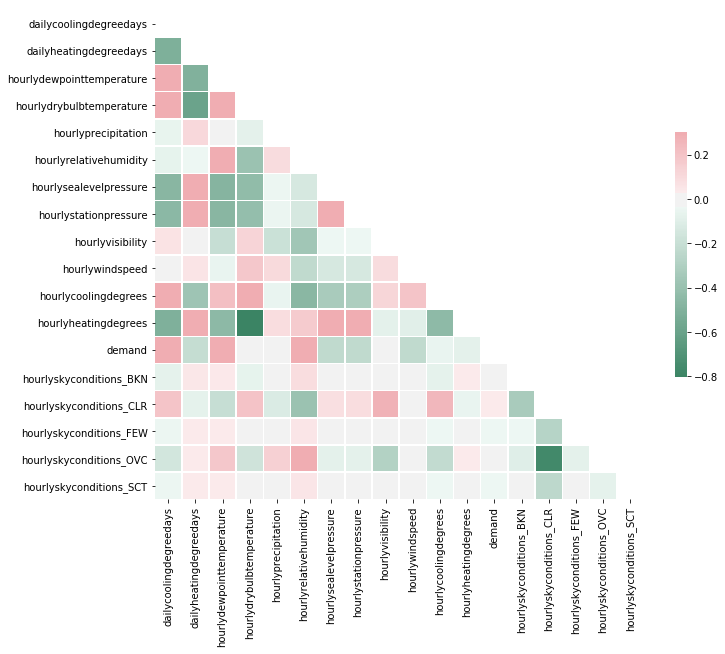

In [8]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Generating collinearity plots for temperature and pressure

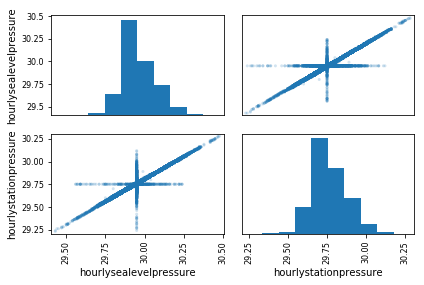

In [9]:
# Pressure
for col in df_eda.columns:
    if col not in ['hourlysealevelpressure', 'hourlystationpressure']:
        df_eda = df_eda.drop(col, axis=1)
axarr = scatter_matrix(df_eda, alpha=.2)
ax = axarr[0,0]
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels([str(round(float(label), 2)) for label in labels])
plt.tight_layout()
plt.show()
plt.close()


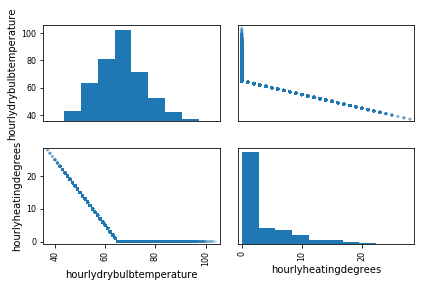

In [10]:
# Temperature
df_temp = df.copy()
for col in df_temp.columns:
    if col not in ['hourlydrybulbtemperature', 'hourlyheatingdegrees']:
        df_temp = df_temp.drop(col, axis=1)
axarr = scatter_matrix(df_temp, alpha=.2)
plt.tight_layout()
plt.show()
plt.close()
del df_temp

In [11]:
def multiple_regression(df):
    X = df[[col for col in df.columns if col != 'demand']]
    y = df['demand']
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print(model.summary())
    return model

mreg = multiple_regression(df)

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     4940.
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        17:11:26   Log-Likelihood:            -2.9438e+05
No. Observations:               39422   AIC:                         5.888e+05
Df Residuals:                   39404   BIC:                         5.890e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


In [12]:
df = df.drop('hourlysealevelpressure', axis=1)

In [13]:
# Add new features based on datetime

cal = calendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())

def create_timeseries_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['isbusinessday']=np.where(df.date.dt.weekday_name.isin(['Saturday','Sunday']),0,1)
    df['isholiday'] = df['date'].isin(holidays).astype(int)
    df['daylight'] = [1 if (hour >= 6 and hour <= 18) else 0 for hour in df['date'].dt.hour]
    return df

df = create_timeseries_features(df.copy())

In [14]:
# save as csv file to continue in another notebook
s3_resource = boto3.resource('s3')

df_buffer = io.StringIO()
df_key = 'dataframes/%s_dataset.csv' % CITY
df.to_csv(df_buffer, compression=None)

s3_resource.Object(bucket, df_key).put(Body=df_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'E63B1E104D7F5CBA',
  'HostId': 'omofGlskgqzuW1mLwIKOoeVr+h/ssB1P/Db5YudL7ZbY8RRYrbzAksB/4M5gWenhsDhgESx9vz8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'omofGlskgqzuW1mLwIKOoeVr+h/ssB1P/Db5YudL7ZbY8RRYrbzAksB/4M5gWenhsDhgESx9vz8=',
   'x-amz-request-id': 'E63B1E104D7F5CBA',
   'date': 'Thu, 16 Jan 2020 17:11:29 GMT',
   'etag': '"b49eb309ec064303866017444b6d4586"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b49eb309ec064303866017444b6d4586"'}